# Introduction

The purpose of this notebook is to explore the BigMart Sales dataset and utilize the data recorded by each store to create a predictive model that can determine the amount of sales of each product at each store. 

## Problem Statement

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

Dataset: https://www.kaggle.com/datasets/shivan118/big-mart-sales-prediction-datasets/data

## Importing Packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
import xgboost
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

## Exploratory Data Analysis & Data Cleaning

Exploring the data will consist of visualizing the distribution of each feature and their relationships to each other.

#### Variable Description

**Item_Identifier**: Unique product ID<br>

**Item_Weight**: Weight of product

**Item_Fat_Content**: Whether the product is low fat or not

**Item_Visibility**: The % of the total display area of all products in a store allocated to the particular product

**Item_Type**: The category to which the product belongs

**Item_MRP**: Maximum Retail Price (list price) of the product

**Outlet_Identifier**: Unique store ID

**Outlet_Establishment_Year**: The year in which the store was established

**Outlet_Size**: The size of the store in terms of ground area covered

**Outlet_Location_Type**: The type of city in which the store is located

**Outlet_Type**: Whether the outlet is just a grocery store or some sort of supermarket

**Item_Outlet_Sales**: Number of sales of the product in a particular store

In [2]:
train = pd.read_csv("train.csv")

In [3]:
train.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

In [4]:
train.shape

(8523, 12)

In [5]:
train.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

There appears to be 5 numerical columns and 7 categorical columns.

In [6]:
train.describe()

Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


**Note:** The null values in the 'Item_Weight' and 'Outlet_Size' cannot be ignored and will be dealt with later.

In [8]:
train.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

There appears to be 1559 unique items for sale as well as 10 different outlets.

In [9]:
train['Outlet_Establishment_Year'].value_counts()

Outlet_Establishment_Year
1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: count, dtype: int64

In [10]:
train.isnull().sum().sort_values(ascending=False)

Outlet_Size                  2410
Item_Weight                  1463
Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [11]:
numerical_columns = train.select_dtypes(exclude='object').columns
numerical_columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

Creating a list of all the numerical features will allow for easy reference in subsequent analysis.

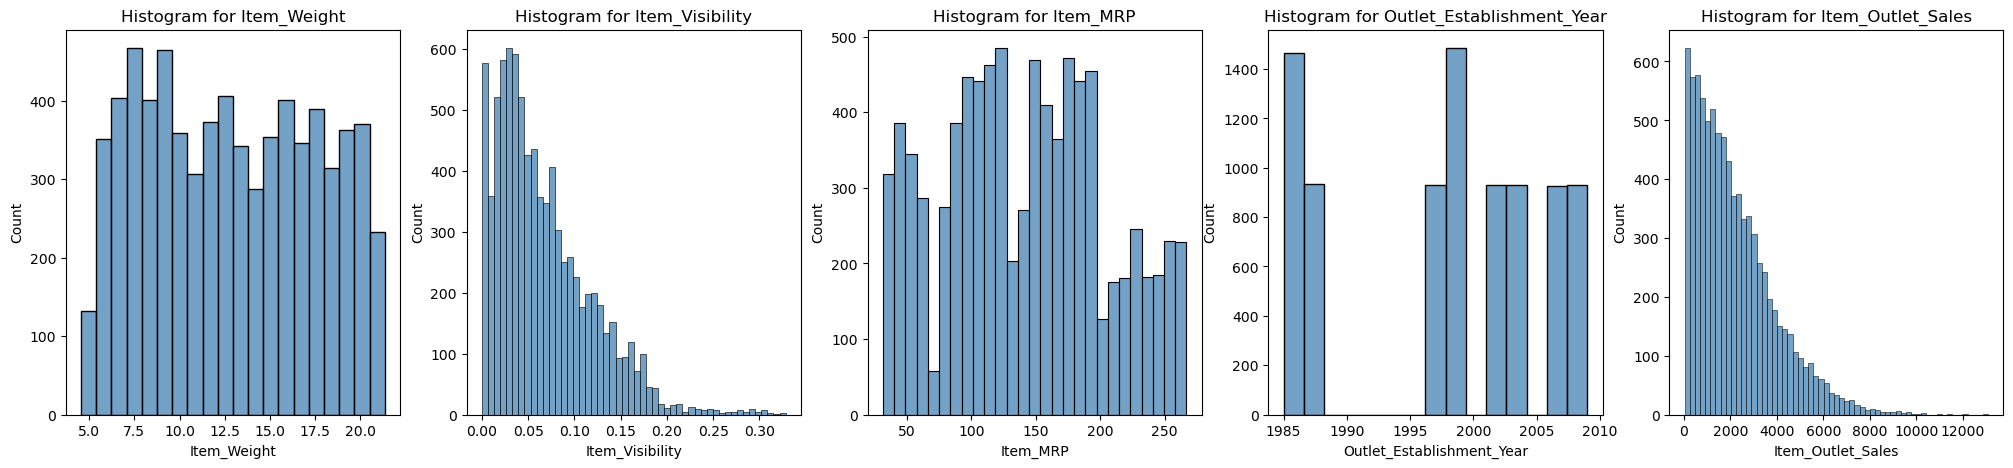

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=len(numerical_columns), figsize=(25, 5))

for i, column_name in enumerate(numerical_columns):
    sns.histplot(data=train, x=column_name, kde=False, ax=ax[i], color="steelblue")
    ax[i].set_ylabel('Count')
    ax[i].set_title(f'Histogram for {column_name}')

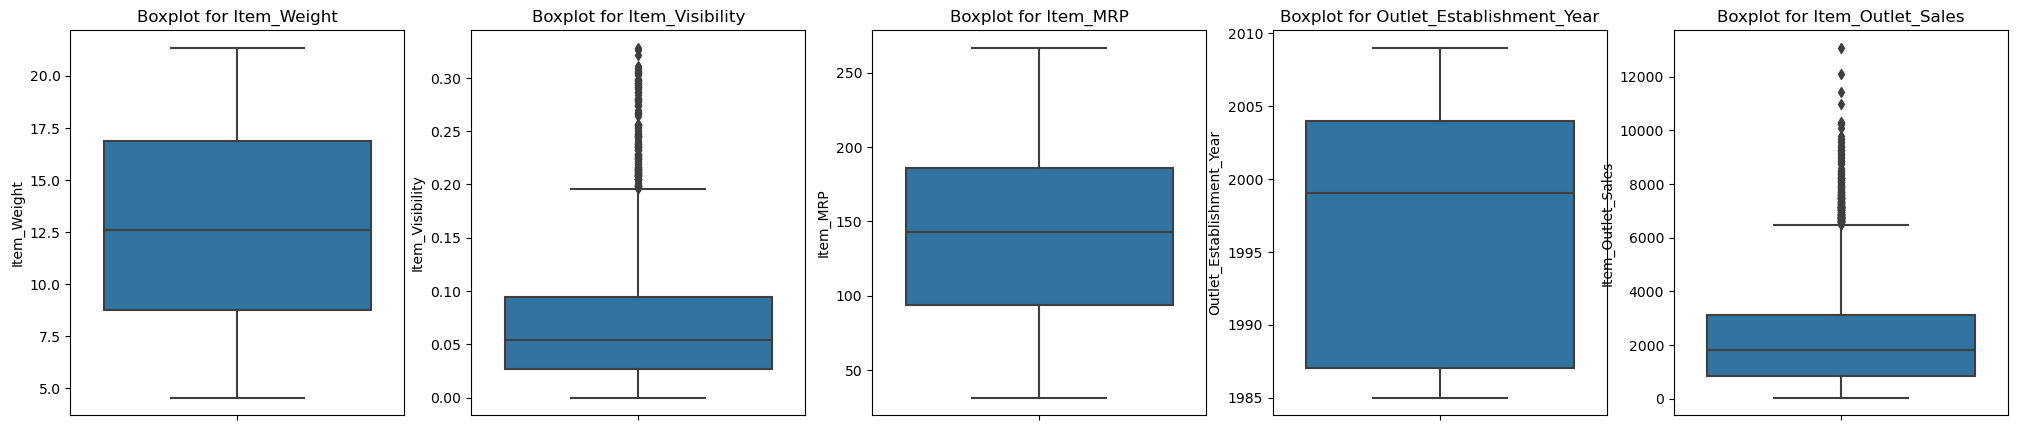

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=len(numerical_columns), figsize=(25, 5))

for i, column_name in enumerate(numerical_columns):
    sns.boxplot(data=train,y=column_name,ax=ax[i])
    ax[i].set_title(f'Boxplot for {column_name}')

**Note:** The values in the Item_Visibility and Item_Outlet_Sales columns have some outliers. Those need to be removed and will be removed.

In [14]:
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")

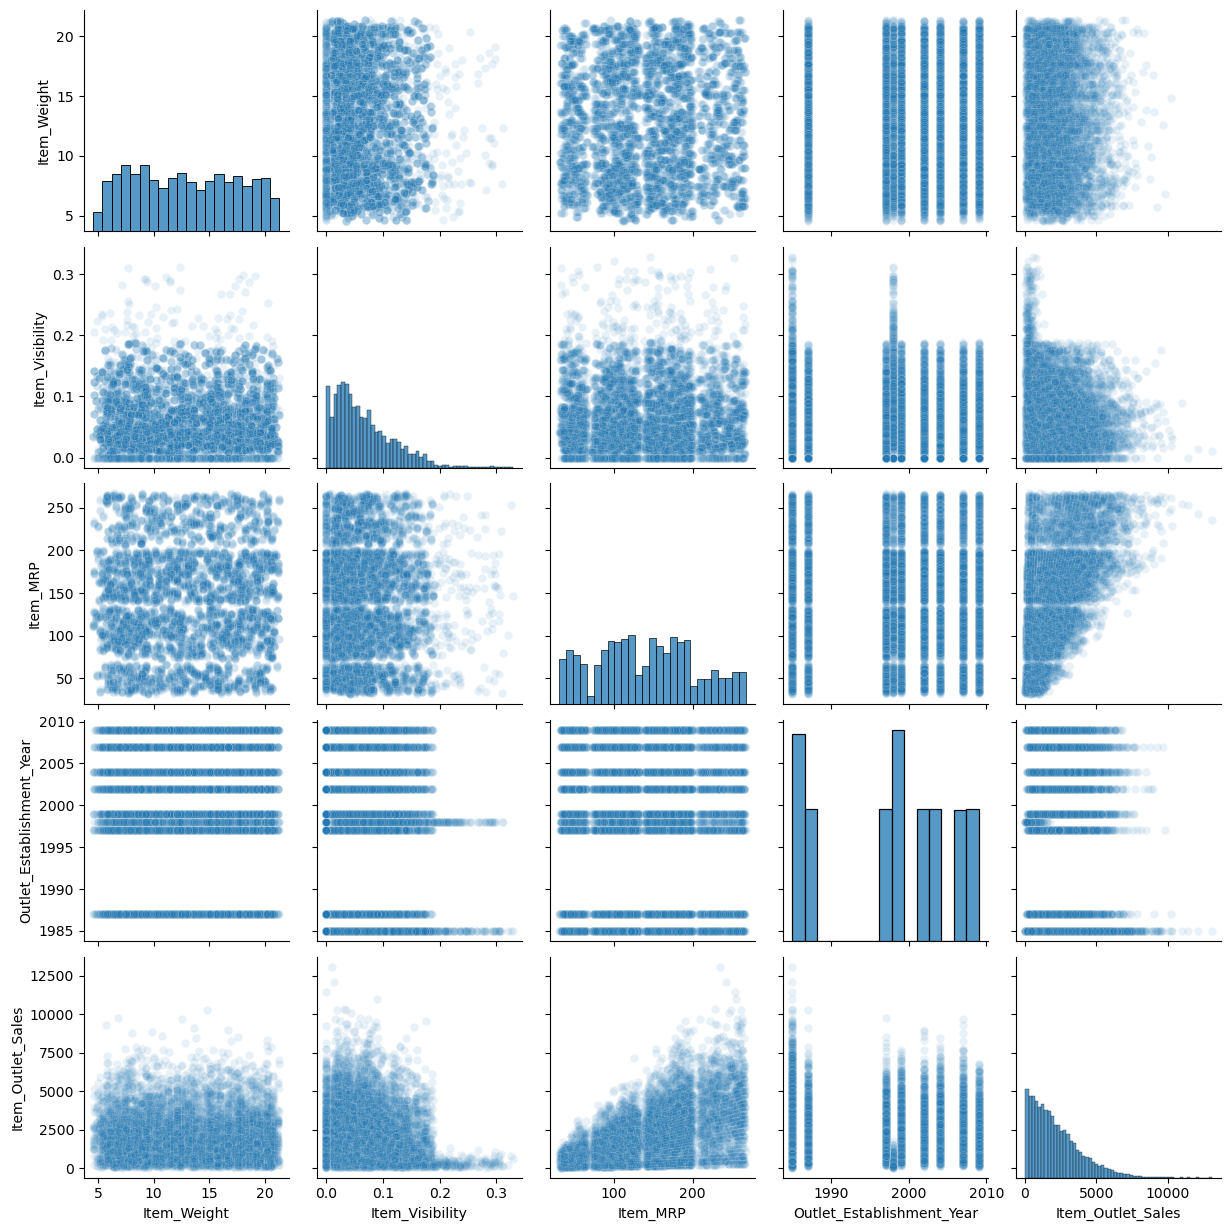

In [15]:
sns.pairplot(train[numerical_columns],plot_kws={'alpha': 0.1});

**Note:** Outlet_Establishment_Year seem to be a categorical variable because of its distribution being limited to the columns shown above. We will treat it as a categorical variable.

In [16]:
train['Outlet_Establishment_Year'] = train['Outlet_Establishment_Year'].astype('object')
train.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year     object
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [17]:
numerical_columns = train.select_dtypes(exclude='object').columns

Outlet_Establishment_Year has been changed to a categorical variable and the numerical columns have been updated to exclude Outlet_Establishment_Year.

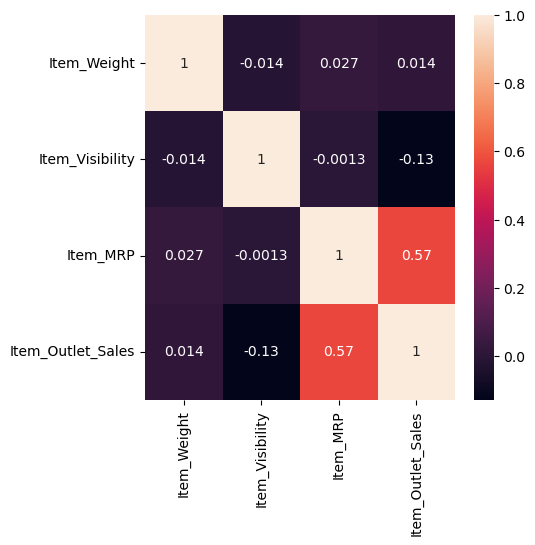

In [18]:
plt.figure(figsize=(5,5))
sns.heatmap(train[numerical_columns].corr(),annot=True);

As displayed in the correlation map above, the feature that seems to have the most impact in determining the Item_Outlet_Sales is Item Maximum Retail Price. The other features do not seem to have a significant impact.

In [19]:
categorical_columns = train.select_dtypes(include='object').columns
categorical_columns

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [20]:
for column in categorical_columns:
    print(f"Number of values in the {column} column:\n{train[column].value_counts() }")
    print('')

Number of values in the Item_Identifier column:
Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64

Number of values in the Item_Fat_Content column:
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

Number of values in the Item_Type column:
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64

Number of values in the Outlet_

In [21]:
train['Item_Identifier'].value_counts()

Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64

**Note:** The Item Identifier column has values that begin with 2 letters that likely indicates what type of product is being sold.

- **FD**: Likely refers to food.
- **DR**: Likely refers to drink.
- **NC**: Likely refers to non-consumable.

We will change this column to only use the type of product being sold.

In [22]:
train['Item_Identifier'] = train['Item_Identifier'].str[0:2]
train.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0              FD         9.30          Low Fat         0.016047   
1              DR         5.92          Regular         0.019278   
2              FD        17.50          Low Fat         0.016760   
3              FD        19.20          Regular         0.000000   
4              NC         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

  Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                      1999      Medium               Tier 1   
1                      2009      Medium               Tier 3   
2                      1999      Medium               Tier 1   
3                      1998         NaN               Tier 3   
4                      1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

In [23]:
train['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

**Note:** The Item_Fat_Content column has different ways to label low fat and regular products. This will be changed to only have the Low Fat and Regular label.

In [24]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].map({
    'Low Fat' : 'Low Fat',
    'Regular' : 'Regular',
    'LF' : 'Low Fat',
    'low fat' : 'Low Fat',
    'reg' : 'Regular'
})

In [25]:
train['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

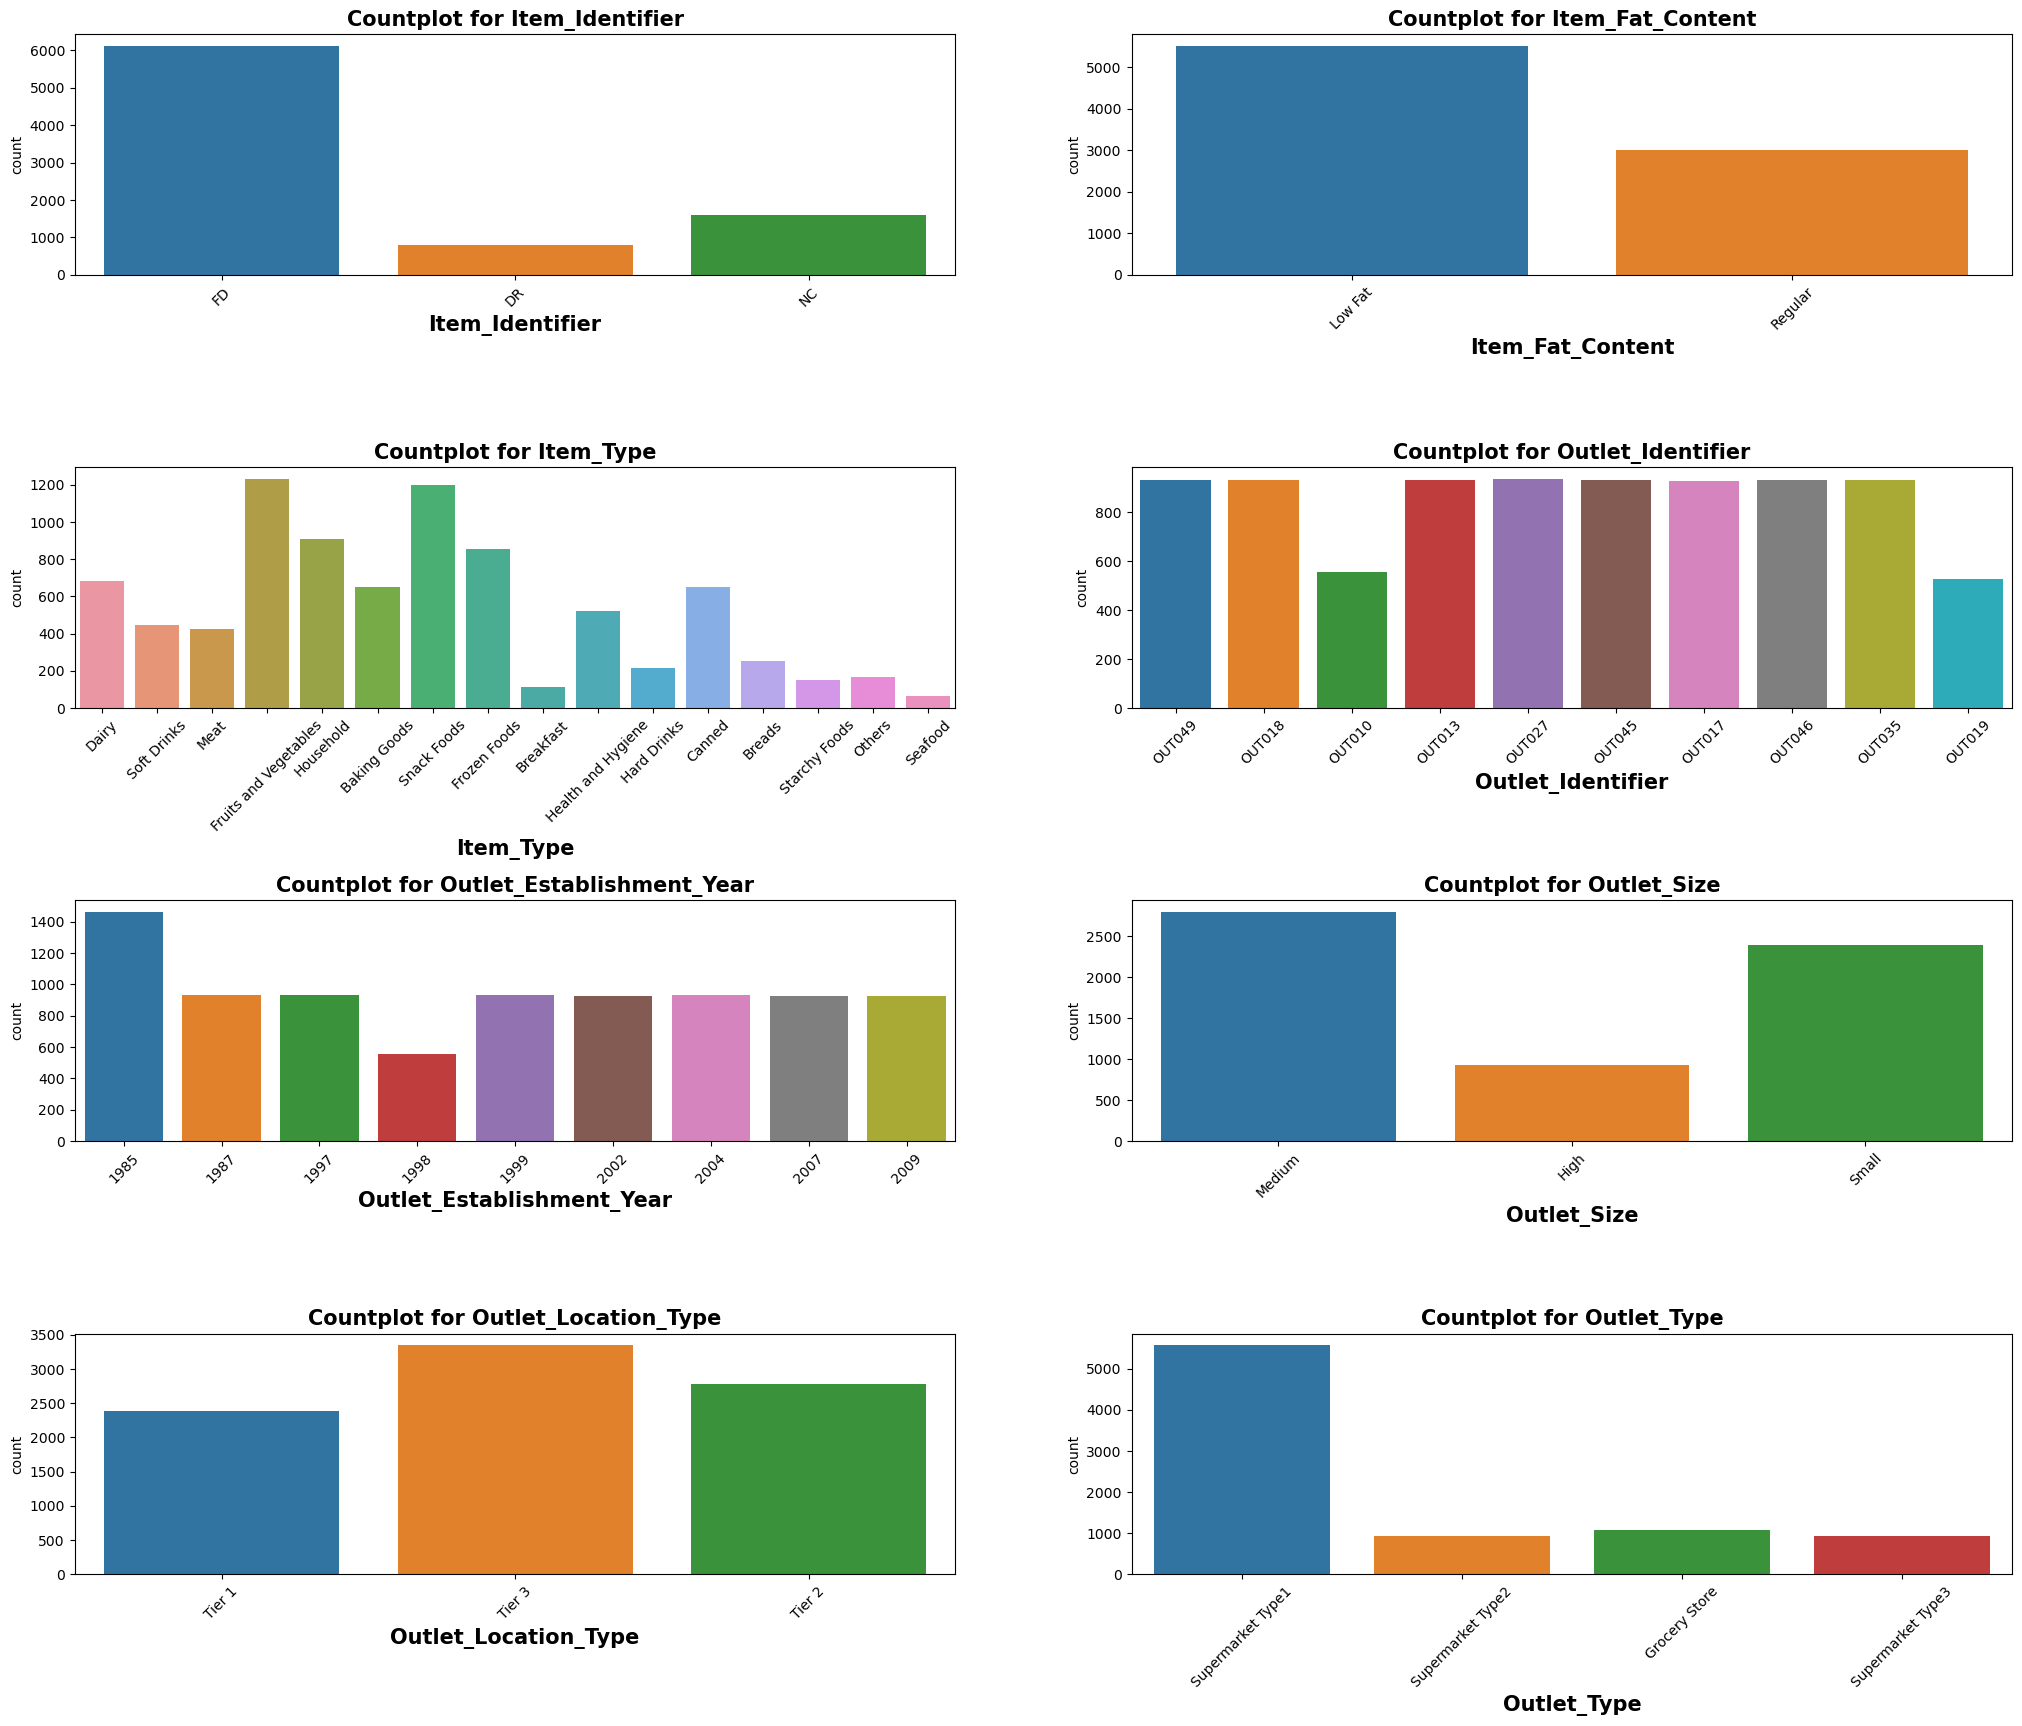

In [26]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(25, 20))

for i, col in enumerate(categorical_columns):
    graph = sns.countplot(x=col, data=train, ax=ax[i // 2][i % 2])
    graph.set_xticklabels(graph.get_xticklabels(), rotation=45)
    graph.set_xlabel(col, fontweight='bold',fontsize=15)
    graph.set_title(f'Countplot for {col}', fontweight='bold',fontsize=15)
    
plt.subplots_adjust(hspace=.8)

**Observations:**

 - The most sold type of product is food with fruits and vegetables and snacks being predominant. 
 - More low fat products are offered than regular products. 
 - There are relatively small amount of products being sold at large outlets.
 - Most of the products sold come from supermarkets and more specifically, type 1.

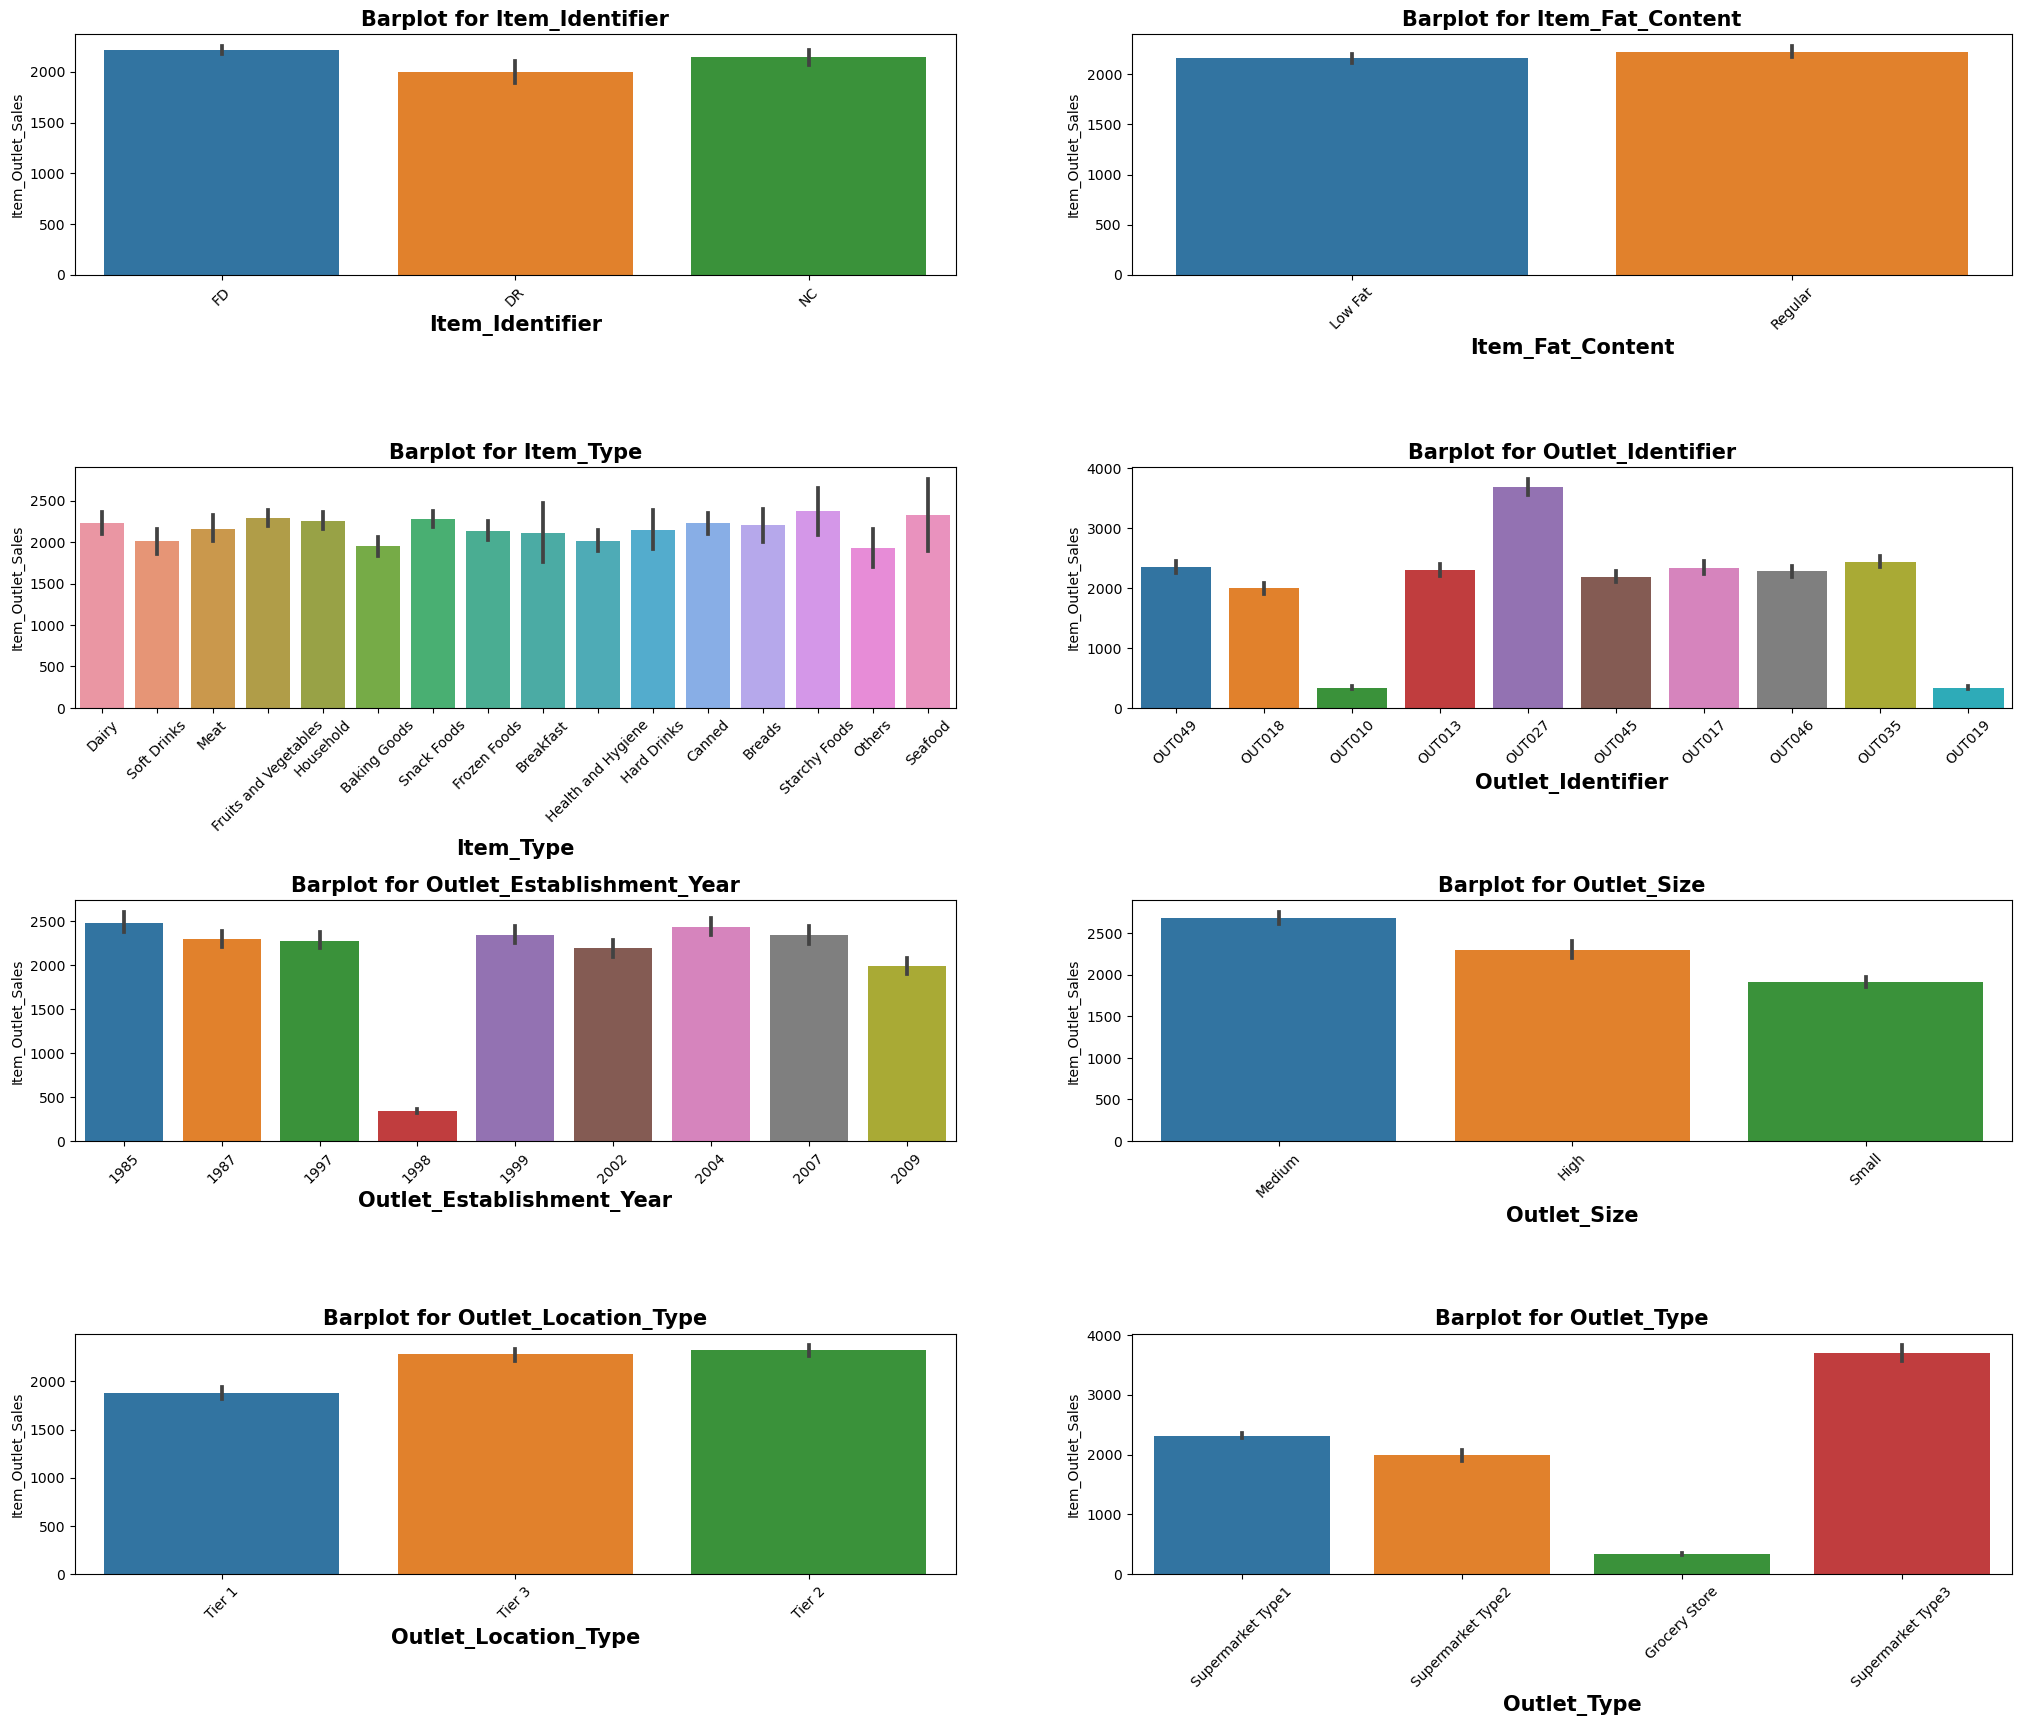

In [27]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(25, 20))

for i, col in enumerate(categorical_columns):
    graph = sns.barplot(x=col, data=train, y='Item_Outlet_Sales',ax=ax[i // 2][i % 2])
    graph.set_xticklabels(graph.get_xticklabels(), rotation=45)
    graph.set_xlabel(col, fontweight='bold',fontsize=15)
    graph.set_title(f'Barplot for {col}', fontweight='bold',fontsize=15)
    
plt.subplots_adjust(hspace=.8)

**Observations:**

 - Item type and fat content generally do not have a statistically significant difference in sale amount in comparison with their counterparts.
 - Outlet 027 sells the most products by a huge margin while outlets 010 and 019 sell the least products by a huge margin. The other outlets have a comparable sale amount.
 - The outlet established in 1999 sells the least product by an enormous margin.
 - Tier 1 outlet locations have lower sales by a small but significant amount.
 - Grocery stores sell the least, followed by supermarket types 1 and 2, and supermarket type 3 sells the most by a very significant margin.

In [28]:
numerical_variables = ['Item_Weight', 'Item_Visibility', 'Item_MRP']

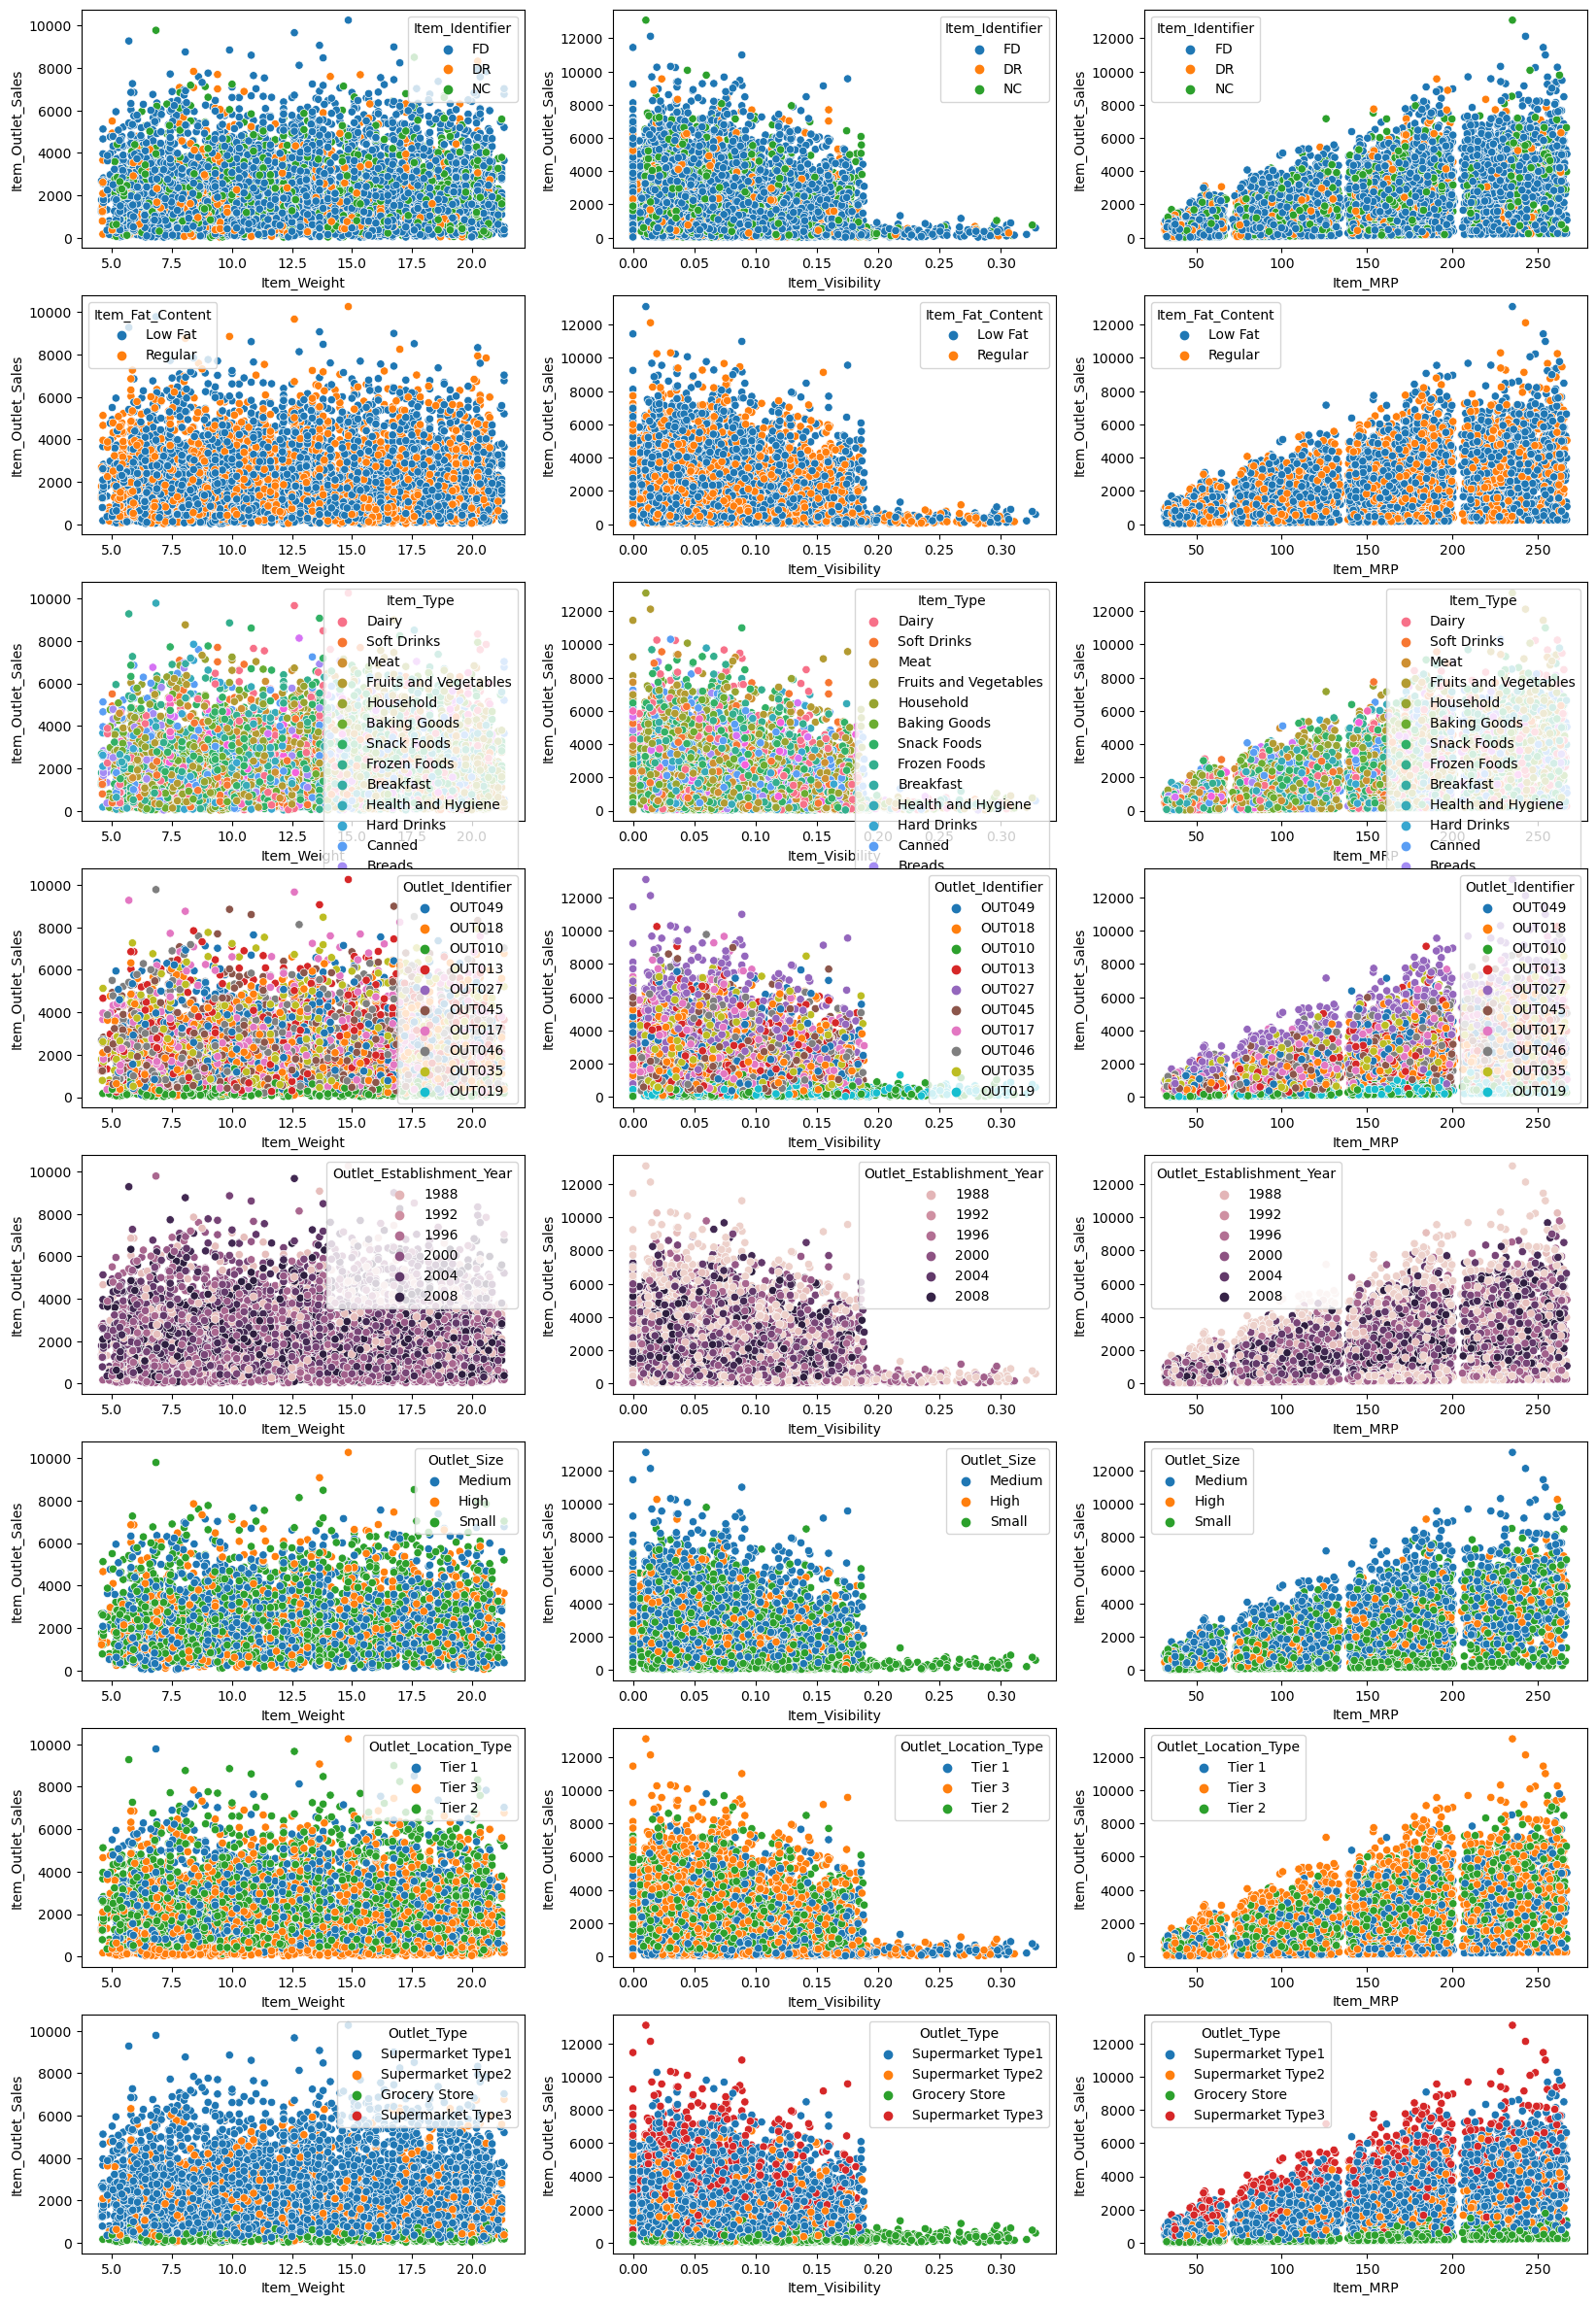

In [29]:
fig, ax = plt.subplots(nrows=len(categorical_columns),ncols=3,figsize=(20,30))

for i,col in enumerate(numerical_variables):
    for index,column in enumerate(categorical_columns):
        sns.scatterplot(data=train,x=col,y='Item_Outlet_Sales',ax=ax[index][i%3],hue=column)

**Observations:**

 - Outlet type and the outlet identifier appear to have the biggest effect on the amount of sales. The other features do not have a clear effect.

In [30]:
train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

These NaN values can be dealt with in different ways. However, they cannot stay in the dataset.

In [31]:
train.shape

(8523, 12)

### Approach 1 - Dropping NaN values

This approach will drop all of the rows with a NaN value in ay of the columns.

In [32]:
train_no_na = train.dropna()
train_no_na

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0                 FD        9.300          Low Fat         0.016047   
1                 DR        5.920          Regular         0.019278   
2                 FD       17.500          Low Fat         0.016760   
4                 NC        8.930          Low Fat         0.000000   
5                 FD       10.395          Regular         0.000000   
...              ...          ...              ...              ...   
8517              FD       20.750          Regular         0.083607   
8518              FD        6.865          Low Fat         0.056783   
8520              NC       10.600          Low Fat         0.035186   
8521              FD        7.210          Regular         0.145221   
8522              DR       14.800          Low Fat         0.044878   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
4              Household   53.8614            OUT013   
5           Baking Goods   51.4008            OUT018   
...                  ...       ...               ...   
8517        Frozen Foods  178.8318            OUT046   
8518         Snack Foods  214.5218            OUT013   
8520  Health and Hygiene   85.1224            OUT035   
8521         Snack Foods  103.1332            OUT018   
8522         Soft Drinks   75.4670            OUT046   

     Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                         1999      Medium               Tier 1   
1                         2009      Medium               Tier 3   
2                         1999      Medium               Tier 1   
4                         1987        High               Tier 3   
5                         2009      Medium               Tier 3   
...                        ...         ...                  ...   
8517                      1997       Small               Tier 1   
8518                      1987        High               Tier 3   
8520                      2004       Small               Tier 2   
8521                      2009      Medium               Tier 3   
8522                      1997       Small               Tier 1   

            Outlet_Type  Item_Outlet_Sales  
0     Supermarket Type1          3735.1380  
1     Supermarket Type2           443.4228  
2     Supermarket Type1          2097.2700  
4     Supermarket Type1           994.7052  
5     Supermarket Type2           556.6088  
...                 ...                ...  
8517  Supermarket Type1          3608.6360  
8518  Supermarket Type1          2778.3834  
8520  Supermarket Type1          1193.1136  
8521  Supermarket Type2          1845.5976  
8522  Supermarket Type1           765.6700  

[4650 rows x 12 columns]

In [33]:
train_no_na.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

### Removing Outliers

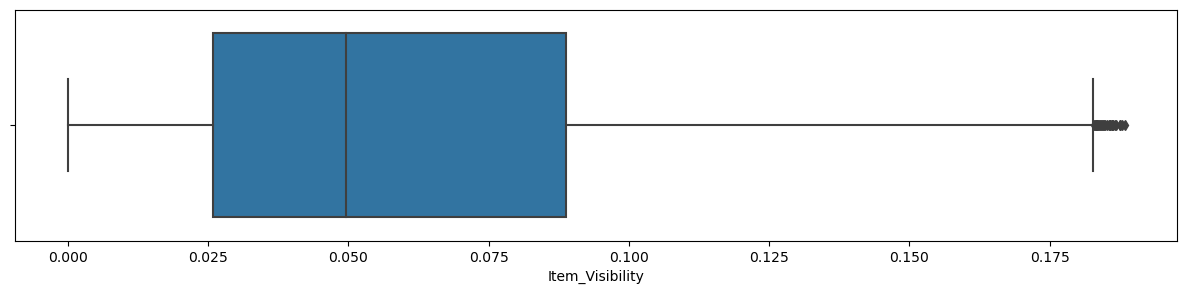

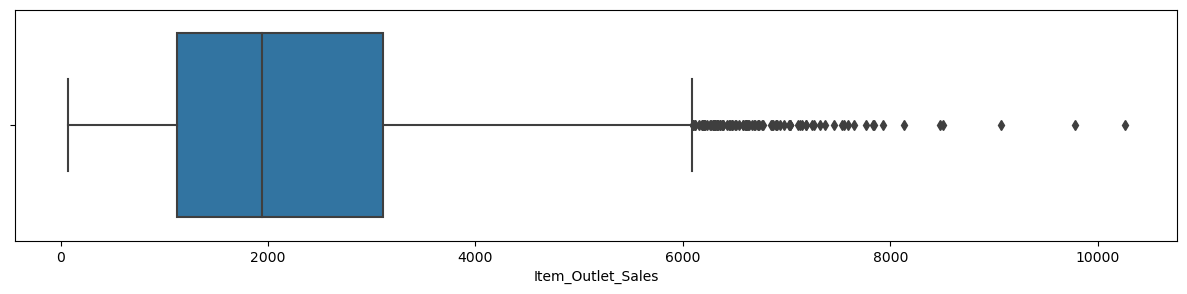

In [34]:
for col in ['Item_Visibility','Item_Outlet_Sales']:
    plt.figure(figsize=(15,3))
    sns.boxplot(x=train_no_na[col],orient='h')
    plt.show()

Many outliers are apparent within the Item_Visibility and Item_Outlet_Sales features. These outliers will be removed using the z-score method. This method determines the points that are more than 3 standard deviations away from the mean, which is the threshold for an outlier. The outliers will then be removed from the dataset.

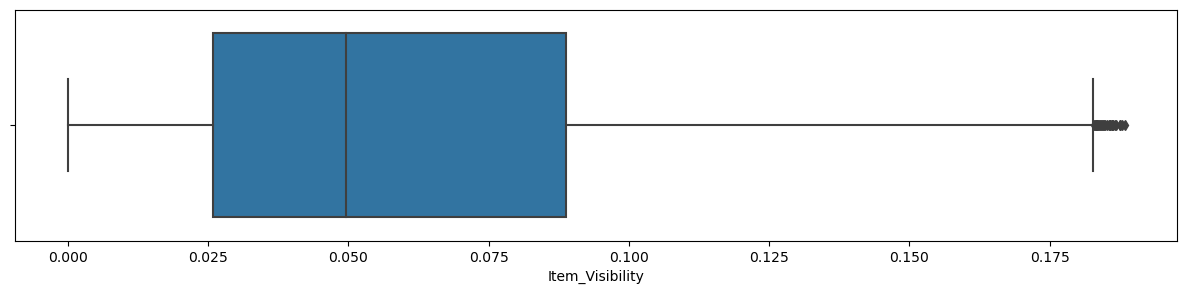

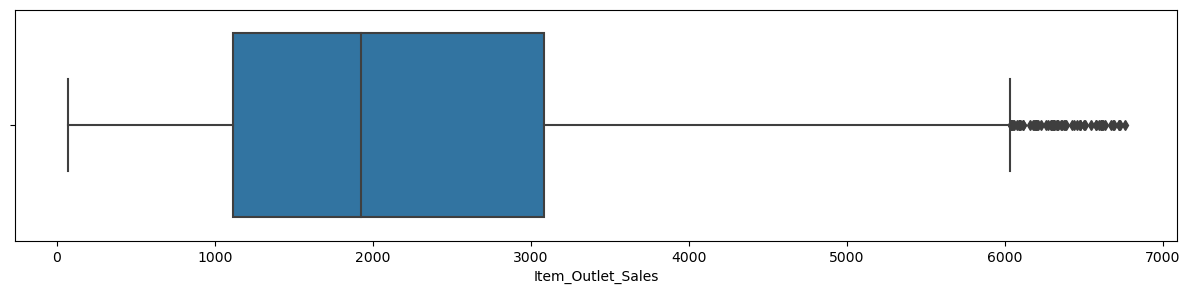

In [35]:
for col in ['Item_Visibility','Item_Outlet_Sales']:

    # Calculate Z-scores
    z_scores = stats.zscore(train_no_na[col])

    # Define a Z-score threshold (e.g., 3)
    z_threshold = 3

    # Identify outliers
    outliers = abs(z_scores) > z_threshold

    # Remove outliers
    train_no_na_or_outliers = train_no_na[~outliers]

    # Create a boxplot without outliers
    plt.figure(figsize=(15,3))
    sns.boxplot(x=train_no_na_or_outliers[col],orient='h')
    plt.show()

As displayed by the boxplots, there are much less outliers present within the dataframe.

In [36]:
train_no_na.shape , train_no_na_or_outliers.shape

((4650, 12), (4613, 12))

37 rows were removed due to being outliers.

In [37]:
train_no_na_or_outliers.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0              FD        9.300          Low Fat         0.016047   
1              DR        5.920          Regular         0.019278   
2              FD       17.500          Low Fat         0.016760   
4              NC        8.930          Low Fat         0.000000   
5              FD       10.395          Regular         0.000000   

      Item_Type  Item_MRP Outlet_Identifier Outlet_Establishment_Year  \
0         Dairy  249.8092            OUT049                      1999   
1   Soft Drinks   48.2692            OUT018                      2009   
2          Meat  141.6180            OUT049                      1999   
4     Household   53.8614            OUT013                      1987   
5  Baking Goods   51.4008            OUT018                      2009   

  Outlet_Size Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  
0      Medium               Tier 1  Supermarket Type1          3735.1380  
1      Medium               Tier 3  Supermarket Type2           443.4228  
2      Medium               Tier 1  Supermarket Type1          2097.2700  
4        High               Tier 3  Supermarket Type1           994.7052  
5      Medium               Tier 3  Supermarket Type2           556.6088

### One Hot Encoding

The machine learning model cannot understand the strings used in each categorical feature. To handle this, One Hot Enoding will be used. One Hot Encoding will distinguish the unique values in each categorical feature into 1s and 0s, in this case True or False, to allow for the machine learning model to discern each value and make use of it during its prediction.

In [38]:
train_no_na_or_outliers = pd.get_dummies(train_no_na_or_outliers,columns=categorical_columns,drop_first=True)

In [39]:
train_no_na_or_outliers.columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales',
       'Item_Identifier_FD', 'Item_Identifier_NC', 'Item_Fat_Content_Regular',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Establishment_Year_1997', 'Outlet_Establishment_Year_1999',
       'Outlet_Establishment_Year_2004', 'Outlet_Establishment_Year_2009',
       'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Supermarket Type2'],
      dtyp

In [40]:
train_no_na_or_outliers.head()

Item_Weight  Item_Visibility  Item_MRP  Item_Outlet_Sales  \
0        9.300         0.016047  249.8092          3735.1380   
1        5.920         0.019278   48.2692           443.4228   
2       17.500         0.016760  141.6180          2097.2700   
4        8.930         0.000000   53.8614           994.7052   
5       10.395         0.000000   51.4008           556.6088   

   Item_Identifier_FD  Item_Identifier_NC  Item_Fat_Content_Regular  \
0                True               False                     False   
1               False               False                      True   
2                True               False                     False   
4               False                True                     False   
5                True               False                      True   

   Item_Type_Breads  Item_Type_Breakfast  Item_Type_Canned  ...  \
0             False                False             False  ...   
1             False                False             False  ...   
2             False                False             False  ...   
4             False                False             False  ...   
5             False                False             False  ...   

   Outlet_Identifier_OUT049  Outlet_Establishment_Year_1997  \
0                      True                           False   
1                     False                           False   
2                      True                           False   
4                     False                           False   
5                     False                           False   

   Outlet_Establishment_Year_1999  Outlet_Establishment_Year_2004  \
0                            True                           False   
1                           False                           False   
2                            True                           False   
4                           False                           False   
5                           False                           False   

   Outlet_Establishment_Year_2009  Outlet_Size_Medium  Outlet_Size_Small  \
0                           False                True              False   
1                            True                True              False   
2                           False                True              False   
4                           False               False              False   
5                            True                True              False   

   Outlet_Location_Type_Tier 2  Outlet_Location_Type_Tier 3  \
0                        False                        False   
1                        False                         True   
2                        False                        False   
4                        False                         True   
5                        False                         True   

   Outlet_Type_Supermarket Type2  
0                          False  
1                           True  
2                          False  
4                          False  
5                           True  

[5 rows x 35 columns]

In [41]:
X = train_no_na_or_outliers.drop('Item_Outlet_Sales',axis=1)
y = train_no_na_or_outliers['Item_Outlet_Sales']

Splitting the dataset into the independent variables and the dependent variable is necessary for the machine learning algorithms. The independent variables consist of all of the features except for the amount of sales. The dependent variable consists of the amount of sales.

In [42]:
X.head()

Item_Weight  Item_Visibility  Item_MRP  Item_Identifier_FD  \
0        9.300         0.016047  249.8092                True   
1        5.920         0.019278   48.2692               False   
2       17.500         0.016760  141.6180                True   
4        8.930         0.000000   53.8614               False   
5       10.395         0.000000   51.4008                True   

   Item_Identifier_NC  Item_Fat_Content_Regular  Item_Type_Breads  \
0               False                     False             False   
1               False                      True             False   
2               False                     False             False   
4                True                     False             False   
5               False                      True             False   

   Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
0                False             False             True  ...   
1                False             False            False  ...   
2                False             False            False  ...   
4                False             False            False  ...   
5                False             False            False  ...   

   Outlet_Identifier_OUT049  Outlet_Establishment_Year_1997  \
0                      True                           False   
1                     False                           False   
2                      True                           False   
4                     False                           False   
5                     False                           False   

   Outlet_Establishment_Year_1999  Outlet_Establishment_Year_2004  \
0                            True                           False   
1                           False                           False   
2                            True                           False   
4                           False                           False   
5                           False                           False   

   Outlet_Establishment_Year_2009  Outlet_Size_Medium  Outlet_Size_Small  \
0                           False                True              False   
1                            True                True              False   
2                           False                True              False   
4                           False               False              False   
5                            True                True              False   

   Outlet_Location_Type_Tier 2  Outlet_Location_Type_Tier 3  \
0                        False                        False   
1                        False                         True   
2                        False                        False   
4                        False                         True   
5                        False                         True   

   Outlet_Type_Supermarket Type2  
0                          False  
1                           True  
2                          False  
4                          False  
5                           True  

[5 rows x 34 columns]

In [43]:
X.shape

(4613, 34)

In [44]:
y.head()

0    3735.1380
1     443.4228
2    2097.2700
4     994.7052
5     556.6088
Name: Item_Outlet_Sales, dtype: float64

In [45]:
y.shape

(4613,)

In [46]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

A 80%-20% split for training and test sets will allow for enough data for the machine learning model to learn from and to test its ability.

### Regression Modeling

Various regression models will be used to try and predict the amount of sales. Pipelines will be used that first scale the data in a manner that helps the machine learning model understand the data and then fits a model to predict the number of sales.

To evaluate the performance of the models, their accuracy in predicting for the training sets and test sets will be recorded. Also, their RMSE (Root Mean Squared Error) will be recorded. The RMSE is a metric that measures how close the model's predictions are to the actual values. Higher accuracies and lower RMSE indicate better predictions.

In [47]:
lin_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

lin_reg_pipeline.fit(X_train,y_train)

print('Training Accuracy:',lin_reg_pipeline.score(X_train, y_train))
print('Test Accuracy:',lin_reg_pipeline.score(X_test, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test,lin_reg_pipeline.predict(X_test))))

Training Accuracy: 0.47058171809653404
Test Accuracy: 0.4785331805916949
RMSE: 1048.209507020436


For this linear regression, the training accuracy is higher than the test accuracy, meaning that this model is beginning to overfit the data. Overfitting indicates that the model understands the training data too well but does not quite understand the patterns or relationships. The model would not be able to accurately predict using new data if it overfits.

In [48]:
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RidgeCV())
])

ridge_pipeline.fit(X_train, y_train)

print('Training Accuracy:', ridge_pipeline.score(X_train, y_train))
print('Test Accuracy:', ridge_pipeline.score(X_test, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, ridge_pipeline.predict(X_test))))

Training Accuracy: 0.4705782034397983
Test Accuracy: 0.4783419059201237
RMSE: 1048.4017316640416


Ridge regression seems to have some overfitting as well.

In [49]:
forest = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])

forest.fit(X_train, y_train)

print('Training Accuracy:', forest.score(X_train, y_train))
print('Test Accuracy:', forest.score(X_test, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, forest.predict(X_test))))

Training Accuracy: 0.9143887134182043
Test Accuracy: 0.41803561992557914
RMSE: 1107.345018788463


Random Forest Regression greatly overfits the data, as displayed by its large gap between training and test accuracy.

In [50]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor(n_neighbors=5)) 
])

knn_pipeline.fit(X_train, y_train)

print('Training Accuracy:', knn_pipeline.score(X_train, y_train))
print('Test Accuracy:', knn_pipeline.score(X_test, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, knn_pipeline.predict(X_test))))

Training Accuracy: 0.5273527717239966
Test Accuracy: 0.26265928330323685
RMSE: 1246.4327823303613


K-Nearest Neighbor Regression also greatly overfits the data.

In [51]:
lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

lasso.fit(X_train, y_train)

print('Training Accuracy:', lasso.score(X_train, y_train))
print('Test Accuracy:', lasso.score(X_test, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, lasso.predict(X_test))))

Training Accuracy: 0.47056982255172053
Test Accuracy: 0.4787151622619078
RMSE: 1048.0265888029635


Lasso regression has a slightly higher training accuracy, indicating that it is beginning to overfit the data.

In [52]:
gbr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor())
])

gbr.fit(X_train, y_train)

print('Training Accuracy:', gbr.score(X_train, y_train))
print('Test Accuracy:', gbr.score(X_test, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, gbr.predict(X_test))))

Training Accuracy: 0.5321715132666582
Test Accuracy: 0.4585428697217765
RMSE: 1068.111996910167


Gradient Boosting Regression is likely overfitting, but not to the extreme of other models.

In [53]:
xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor())
])

xgb.fit(X_train, y_train)

print('Training Accuracy:', xgb.score(X_train, y_train))
print('Test Accuracy:', xgb.score(X_test, y_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, xgb.predict(X_test))))

Training Accuracy: 0.8833856170757427
Test Accuracy: 0.30189777681040975
RMSE: 1212.8141771473208


eXtreme Gradient Boosting is greatly overfitting.

**Summary:**

By dropping the NaN values, Lasso and Linear Regression seem to be the best predictive models as they have the lowest RMSE values and are least prone to overfitting.

### Approach 2 - Filling in NaN Values

For this approach, the NaN values will be filled in rather than removed. Values can be filled in in different ways.

In [54]:
train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

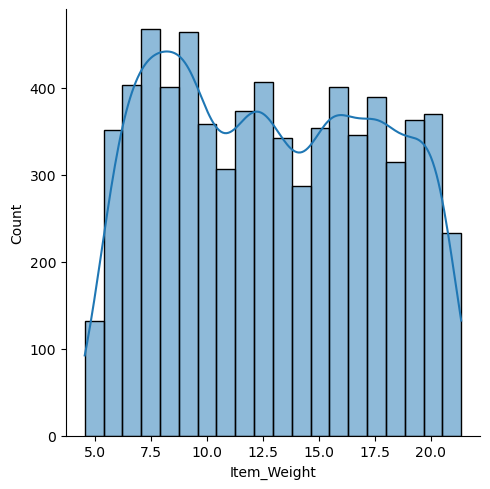

In [55]:
sns.displot(train['Item_Weight'],kde=True,);

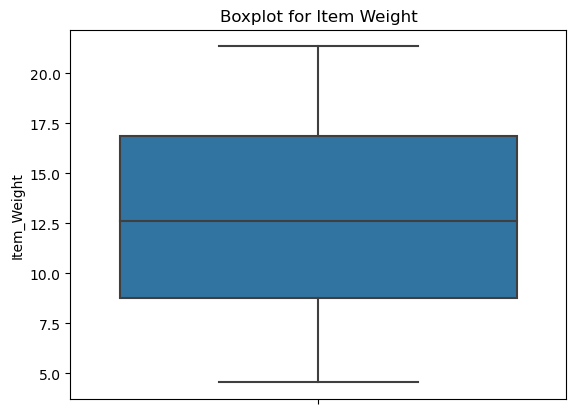

In [56]:
sns.boxplot(data=train,y='Item_Weight');
plt.title('Boxplot for Item Weight');

**Note:** Item Weight is a numerical feature and appears to have a fairly random distribution. This means that filling in the NaN values with the mean is viable and will be performed.

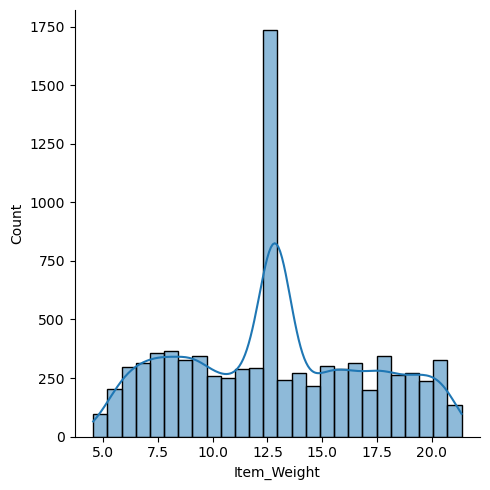

In [57]:
train_fill_na1 = train.copy()
train_fill_na1['Item_Weight'] = train['Item_Weight'].fillna(train['Item_Weight'].mean())
sns.displot(train_fill_na1['Item_Weight'],kde=True,);

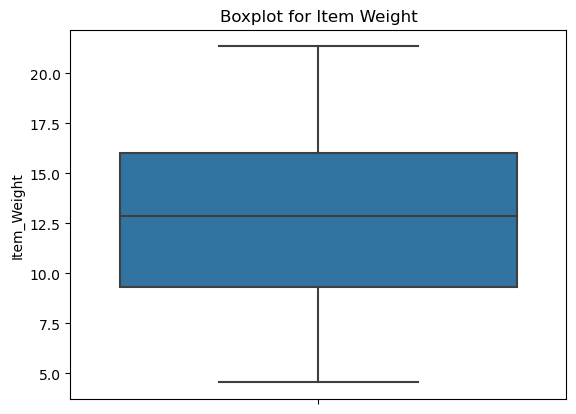

In [58]:
sns.boxplot(data=train_fill_na1,y='Item_Weight');
plt.title('Boxplot for Item Weight');

In [59]:
train_fill_na1.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

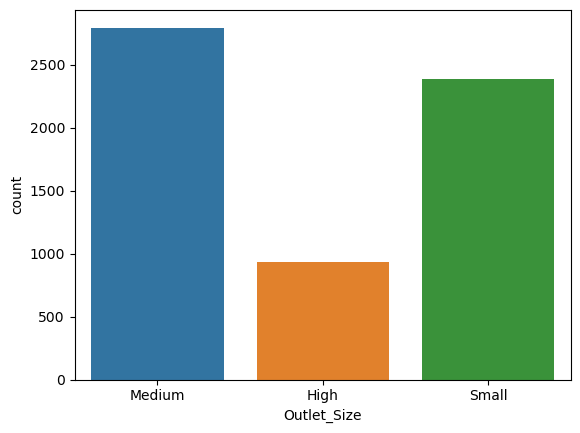

In [60]:
sns.countplot(data=train_fill_na1,x='Outlet_Size');

**Note:** Outlet Size is a categorical variable so the NaN values will be filled in with the mode, which is "Medium". This is a simple and interpretable way to handle the NaN values.

In [61]:
train_fill_na2 = train_fill_na1.copy()
train_fill_na2['Outlet_Size'] = train_fill_na2['Outlet_Size'].fillna(train_fill_na2['Outlet_Size'].dropna().mode()[0])
train_fill_na2.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [62]:
train_fill_na2['Outlet_Size'].value_counts()

Outlet_Size
Medium    5203
Small     2388
High       932
Name: count, dtype: int64

### Outlier Removal

The outliers need to be removed once more.

In [63]:
for col in ['Item_Visibility','Item_Outlet_Sales']:

    # Calculate Z-scores
    z_scores = stats.zscore(train_fill_na2[col])

    # Define a Z-score threshold (e.g., 3)
    z_threshold = 3

    # Identify outliers
    outliers = abs(z_scores) > z_threshold

    # Remove outliers
    train_fill_na_no_outliers = train_fill_na2[~outliers]

### One Hot Encoding

The categorical variables need to be One Hot Encoded once again for this new dataframe.

In [64]:
train_fill_na_no_outliers2 = pd.get_dummies(train_fill_na_no_outliers,columns=categorical_columns,drop_first=True)

In [65]:
X_fillna1 = train_fill_na_no_outliers2.drop('Item_Outlet_Sales',axis=1)
y_fillna1 = train_fill_na_no_outliers2['Item_Outlet_Sales']

In [66]:
X_train_fillna , X_test_fillna , y_train_fillna , y_test_fillna = train_test_split(X_fillna1,y_fillna1,test_size=.2)

**Note:** A new train, test split needs to be created because the dataframe used in this approach is different from the one used previously in approach 1.

### Regression Modeling

The same regression models will be performed on the new dataset.

In [67]:
pipelines = [lin_reg_pipeline,ridge_pipeline,forest,knn_pipeline,lasso,gbr,xgb]
approach_1_training_accuracies = []
approach_1_test_accuracies = []
approach_1_RMSEs = []
approach_2_training_accuracies = []
approach_2_test_accuracies = []
approach_2_RMSEs = []
model_names = []


for pipeline in pipelines:
    model_name = type(pipeline.named_steps['model']).__name__
    model_names = np.append(model_names,model_name)
    pipeline.fit(X_train,y_train)
    approach_1_training_accuracy = pipeline.score(X_train, y_train)
    approach_1_training_accuracies = np.append(approach_1_training_accuracies,approach_1_training_accuracy)
    approach_1_test_accuracy = pipeline.score(X_test, y_test)
    approach_1_test_accuracies = np.append(approach_1_test_accuracies,approach_1_test_accuracy)
    approach_1_RMSE = np.sqrt(mean_squared_error(y_test,pipeline.predict(X_test)))
    approach_1_RMSEs = np.append(approach_1_RMSEs,approach_1_RMSE)
    
    pipeline.fit(X_train_fillna, y_train_fillna)
    approach_2_training_accuracy = pipeline.score(X_train_fillna, y_train_fillna)
    approach_2_training_accuracies = np.append(approach_2_training_accuracies,approach_2_training_accuracy)
    approach_2_test_accuracy = pipeline.score(X_test_fillna, y_test_fillna)
    approach_2_test_accuracies = np.append(approach_2_test_accuracies,approach_2_test_accuracy)
    approach_2_RMSE = np.sqrt(mean_squared_error(y_test_fillna,pipeline.predict(X_test_fillna)))
    approach_2_RMSEs = np.append(approach_2_RMSEs,approach_2_RMSE)

In [68]:
RMSE_difference = approach_1_RMSEs - approach_2_RMSEs
approach_training_difference = approach_1_training_accuracies - approach_2_training_accuracies
approach_test_difference = approach_1_test_accuracies - approach_2_test_accuracies

data = {
    'Model Name': model_names,
    'Approach 1 Training Accuracy': approach_1_training_accuracies,
    'Approach 1 Test Accuracy' : approach_1_test_accuracies,
    'Approach 1 RMSE' : approach_1_RMSEs,
    'Approach 2 Training Accuracy': approach_2_training_accuracies,
    'Approach 2 Test Accuracy' : approach_2_test_accuracies,
    'Approach 2 RMSE' : approach_2_RMSEs,
    'Approach Training Accuracy Difference (1 - 2)': approach_training_difference,
    'Approach Test Accuracy Difference (1 - 2)' : approach_test_difference,
    'RMSE Difference (1 - 2)':RMSE_difference
}    
    
model_comparison = pd.DataFrame(data)

In [69]:
model_comparison

Model Name  Approach 1 Training Accuracy  \
0           LinearRegression                      0.470582   
1                    RidgeCV                      0.470578   
2      RandomForestRegressor                      0.915896   
3        KNeighborsRegressor                      0.527353   
4                      Lasso                      0.470570   
5  GradientBoostingRegressor                      0.532172   
6               XGBRegressor                      0.883386   

   Approach 1 Test Accuracy  Approach 1 RMSE  Approach 2 Training Accuracy  \
0                  0.478533      1048.209507                      0.568776   
1                  0.478342      1048.401732                      0.568775   
2                  0.408885      1116.016515                      0.940082   
3                  0.262659      1246.432782                      0.651305   
4                  0.478715      1048.026589                      0.568736   
5                  0.459194      1067.469681                      0.631866   
6                  0.301898      1212.814177                      0.865911   

   Approach 2 Test Accuracy  Approach 2 RMSE  \
0                  0.530848      1040.448097   
1                  0.530968      1040.314141   
2                  0.491579      1083.116661   
3                  0.428721      1148.120766   
4                  0.531297      1039.949434   
5                  0.563653      1003.412495   
6                  0.464878      1111.193851   

   Approach Training Accuracy Difference (1 - 2)  \
0                                      -0.098194   
1                                      -0.098197   
2                                      -0.024186   
3                                      -0.123952   
4                                      -0.098166   
5                                      -0.099695   
6                                       0.017474   

   Approach Test Accuracy Difference (1 - 2)  RMSE Difference (1 - 2)  
0                                  -0.052314                 7.761410  
1                                  -0.052626                 8.087590  
2                                  -0.082693                32.899853  
3                                  -0.166062                98.312017  
4                                  -0.052582                 8.077155  
5                                  -0.104459                64.057186  
6                                  -0.162980               101.620326

**Summary:**

 - Approach 2 has higher overall accuracies but also higher RMSEs.
 - Overfitting is prevalent in both approaches.
 - There is no clear **BEST** model due to the comparable accuracies and RMSEs.

### Hyperparameter Tuning

Hyperparameter tuning involves adding parameters to the predictive model in order to yield better predictive results. This will be done to test how much the performance of a model can increase. 

In [70]:
model_comparison.sort_values(by='Approach 2 Training Accuracy')

Model Name  Approach 1 Training Accuracy  \
4                      Lasso                      0.470570   
1                    RidgeCV                      0.470578   
0           LinearRegression                      0.470582   
5  GradientBoostingRegressor                      0.532172   
3        KNeighborsRegressor                      0.527353   
6               XGBRegressor                      0.883386   
2      RandomForestRegressor                      0.915896   

   Approach 1 Test Accuracy  Approach 1 RMSE  Approach 2 Training Accuracy  \
4                  0.478715      1048.026589                      0.568736   
1                  0.478342      1048.401732                      0.568775   
0                  0.478533      1048.209507                      0.568776   
5                  0.459194      1067.469681                      0.631866   
3                  0.262659      1246.432782                      0.651305   
6                  0.301898      1212.814177                      0.865911   
2                  0.408885      1116.016515                      0.940082   

   Approach 2 Test Accuracy  Approach 2 RMSE  \
4                  0.531297      1039.949434   
1                  0.530968      1040.314141   
0                  0.530848      1040.448097   
5                  0.563653      1003.412495   
3                  0.428721      1148.120766   
6                  0.464878      1111.193851   
2                  0.491579      1083.116661   

   Approach Training Accuracy Difference (1 - 2)  \
4                                      -0.098166   
1                                      -0.098197   
0                                      -0.098194   
5                                      -0.099695   
3                                      -0.123952   
6                                       0.017474   
2                                      -0.024186   

   Approach Test Accuracy Difference (1 - 2)  RMSE Difference (1 - 2)  
4                                  -0.052582                 8.077155  
1                                  -0.052626                 8.087590  
0                                  -0.052314                 7.761410  
5                                  -0.104459                64.057186  
3                                  -0.166062                98.312017  
6                                  -0.162980               101.620326  
2                                  -0.082693                32.899853

**Approach 2** will be the approach chosen because it yields higher overall accuracies.
**Lasso Regression** will be chosen because it has a combination of being less prone to overfitting and has one of the smaller RMSEs.

In [71]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

param_grid = {
    'model__alpha': [10,20,30,40],
    'model__max_iter': [30,40,50,60,70,100,1000000],
    'model__warm_start': [False, True]
}

grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the grid search to the data
grid_search.fit(X_train_fillna, y_train_fillna)

print("Best Hyperparameters:", grid_search.best_params_)

best_lasso_pipeline = grid_search.best_estimator_

y_pred_fillna = best_lasso_pipeline.predict(X_test_fillna)
best_lasso_training_accuracy = best_lasso_pipeline.score(X_train_fillna, y_train_fillna)
best_lasso_test_accuracy = best_lasso_pipeline.score(X_test_fillna, y_test_fillna)
rmse_fillna = mean_squared_error(y_test_fillna, y_pred_fillna, squared=False)


print('With Hyperparameter Tuning:')
print('Training Accuracy:',best_lasso_training_accuracy)
print('Test Accuracy:',best_lasso_test_accuracy)
print("Root Mean Squared Error (RMSE):", rmse_fillna)
print()
print('Without Hyperparameter Tuning:')
print('Training Accuracy:',lasso.score(X_train_fillna, y_train_fillna))
print('Test Accuracy:',lasso.score(X_test_fillna, y_test_fillna))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test_fillna,lasso.predict(X_test_fillna))))

Best Hyperparameters: {'model__alpha': 10, 'model__max_iter': 1000000, 'model__warm_start': False}
With Hyperparameter Tuning:
Training Accuracy: 0.5679492034720963
Test Accuracy: 0.533518879798331
Root Mean Squared Error (RMSE): 1037.4816883542799

Without Hyperparameter Tuning:
Training Accuracy: 0.5687361373809673
Test Accuracy: 0.5312971038280154
Root Mean Squared Error (RMSE): 1039.9494342632704


**Summary:**

After hyperparameter tuning, the performance of the Lasso model changed by an unsignificant amount. In this case, hyperparameter tuning worsened the performance, although by a marginal change. 

## Conclusion

**Results:** The best possible prediction percentage obtained was around 56-63%. The models were also subject to overfitting.

**Areas of Improvement:** 
 - More feature engineering could be performed. The features already present could be fiddled with and rearranged to achieve a better prediction rate.
 - Different approaches to filling in NaN values could be tested. Only 1 different approach was tested and it led to better results. Other approaches could also lead to better results.
 - Other regression models could be tested. There are still many models that were not tested in this project that could have produced better results.
 - Other regression models could have been tuned. Tuning all of the models could eventually lead to a model that has a better result than the one found.

**Areas for Exploration:** If future exploration were to be done, some possibilites include recordning new features. New features could be recorded and added to the data to give the models more information to work with, potentially leading to more accurate predictions.

**Model Uses:** A better version of this model could be used in an application that informs stores of their expected sales. This will help them decide how much stock will be needed to avoid shortages as well as surpluses.